In [3]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

In [95]:
time = pd.date_range('2021-01-01', freq="D", periods=356*3)

holiday = calendar().holidays(start=time.min(), end=time.max(), return_name=True)
holiday = pd.get_dummies(holiday, drop_first=False).astype(int)
df = pd.DataFrame(index=time)
holiday_df = df.join(holiday).fillna(0)
holiday_df = holiday_df.resample("W-MON").sum()
t = np.linspace(0, 6*np.pi, len(holiday_df))
betas_holiday_direct = np.random.normal(0, 4, size=len(holiday_df.columns))*np.random.binomial(1, 0.2, size=len(holiday_df.columns))
betas_holiday_indirect = np.random.normal(0, 4, size=len(holiday_df.columns))*np.random.binomial(1, 0.2, size=len(holiday_df.columns)) + betas_holiday_direct
season = np.sin(t) + .3*np.sin(2*t)
season = season/season.max()
holiday_effect = holiday_df.values.dot(betas_holiday_direct)
indirect_holiday_effect = holiday_df.values.dot(betas_holiday_indirect)

category = .2*season + indirect_holiday_effect + np.random.normal(0, .3, size=len(holiday_df))
y = season + holiday_effect + category + np.random.normal(0, .1, size=len(holiday_df))


In [120]:
data = holiday_df.copy()
#data["season"] = season
data["category"] = category
data['sin1'] = np.sin(t)
data['sin2'] = np.sin(2*t)
data['sin3'] = np.sin(3*t)
full_data = data.copy()
full_data['target'] = y
#data = data.drop(columns=['Thanksgiving Day'])
with pm.Model(coords={'IVS': data.columns}) as model:
    betas = pm.Normal("betas", 0, 10, dims=("IVS",))
    y_hat = pm.math.dot(data.values, betas)
    sigma = pm.Exponential("sigma", 1)
    likelihood = pm.Normal("likelihood", y_hat, sigma, observed=y)
    trace = pm.sample(2000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


In [111]:
pd.DataFrame(data=betas_holiday_direct[None, :], columns=holiday_df.columns)

,"Birthday of Martin Luther King, Jr.",Christmas Day,Columbus Day,Independence Day,Juneteenth National Independence Day,Labor Day,Memorial Day,New Year's Day,Thanksgiving Day,Veterans Day,Washington's Birthday
0,0.0,0.0,0.0,2.064175,0.0,0.0,-0.0,-0.0,-0.0,0.0,-2.9619


In [112]:
pd.DataFrame(data=betas_holiday_indirect[None, :], columns=holiday_df.columns)

,"Birthday of Martin Luther King, Jr.",Christmas Day,Columbus Day,Independence Day,Juneteenth National Independence Day,Labor Day,Memorial Day,New Year's Day,Thanksgiving Day,Veterans Day,Washington's Birthday
0,0.0,0.0,0.0,2.064175,0.0,0.0,0.0,-0.727246,11.870275,0.0,-2.9619


In [119]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[Birthday of Martin Luther King, Jr.]",0.564,0.363,-0.089,1.268,0.003,0.003,11554.0,5891.0,1.0
betas[Christmas Day],0.268,0.441,-0.619,1.046,0.004,0.004,13511.0,5746.0,1.0
betas[Columbus Day],-1.005,0.361,-1.698,-0.325,0.003,0.002,12051.0,5958.0,1.0
betas[Independence Day],1.957,0.363,1.255,2.635,0.003,0.002,11261.0,6216.0,1.0
betas[Juneteenth National Independence Day],0.098,0.361,-0.590,0.791,0.003,0.004,13446.0,5804.0,1.0
betas[Labor Day],-0.795,0.355,-1.487,-0.148,0.003,0.002,13250.0,6244.0,1.0
betas[Memorial Day],0.184,0.355,-0.488,0.855,0.003,0.004,13133.0,5753.0,1.0
betas[New Year's Day],0.107,0.355,-0.549,0.783,0.003,0.004,12050.0,5990.0,1.0
betas[Veterans Day],-0.706,0.354,-1.355,-0.043,0.003,0.002,12930.0,6547.0,1.0
betas[Washington's Birthday],-2.054,0.364,-2.760,-1.396,0.003,0.002,11567.0,6533.0,1.0


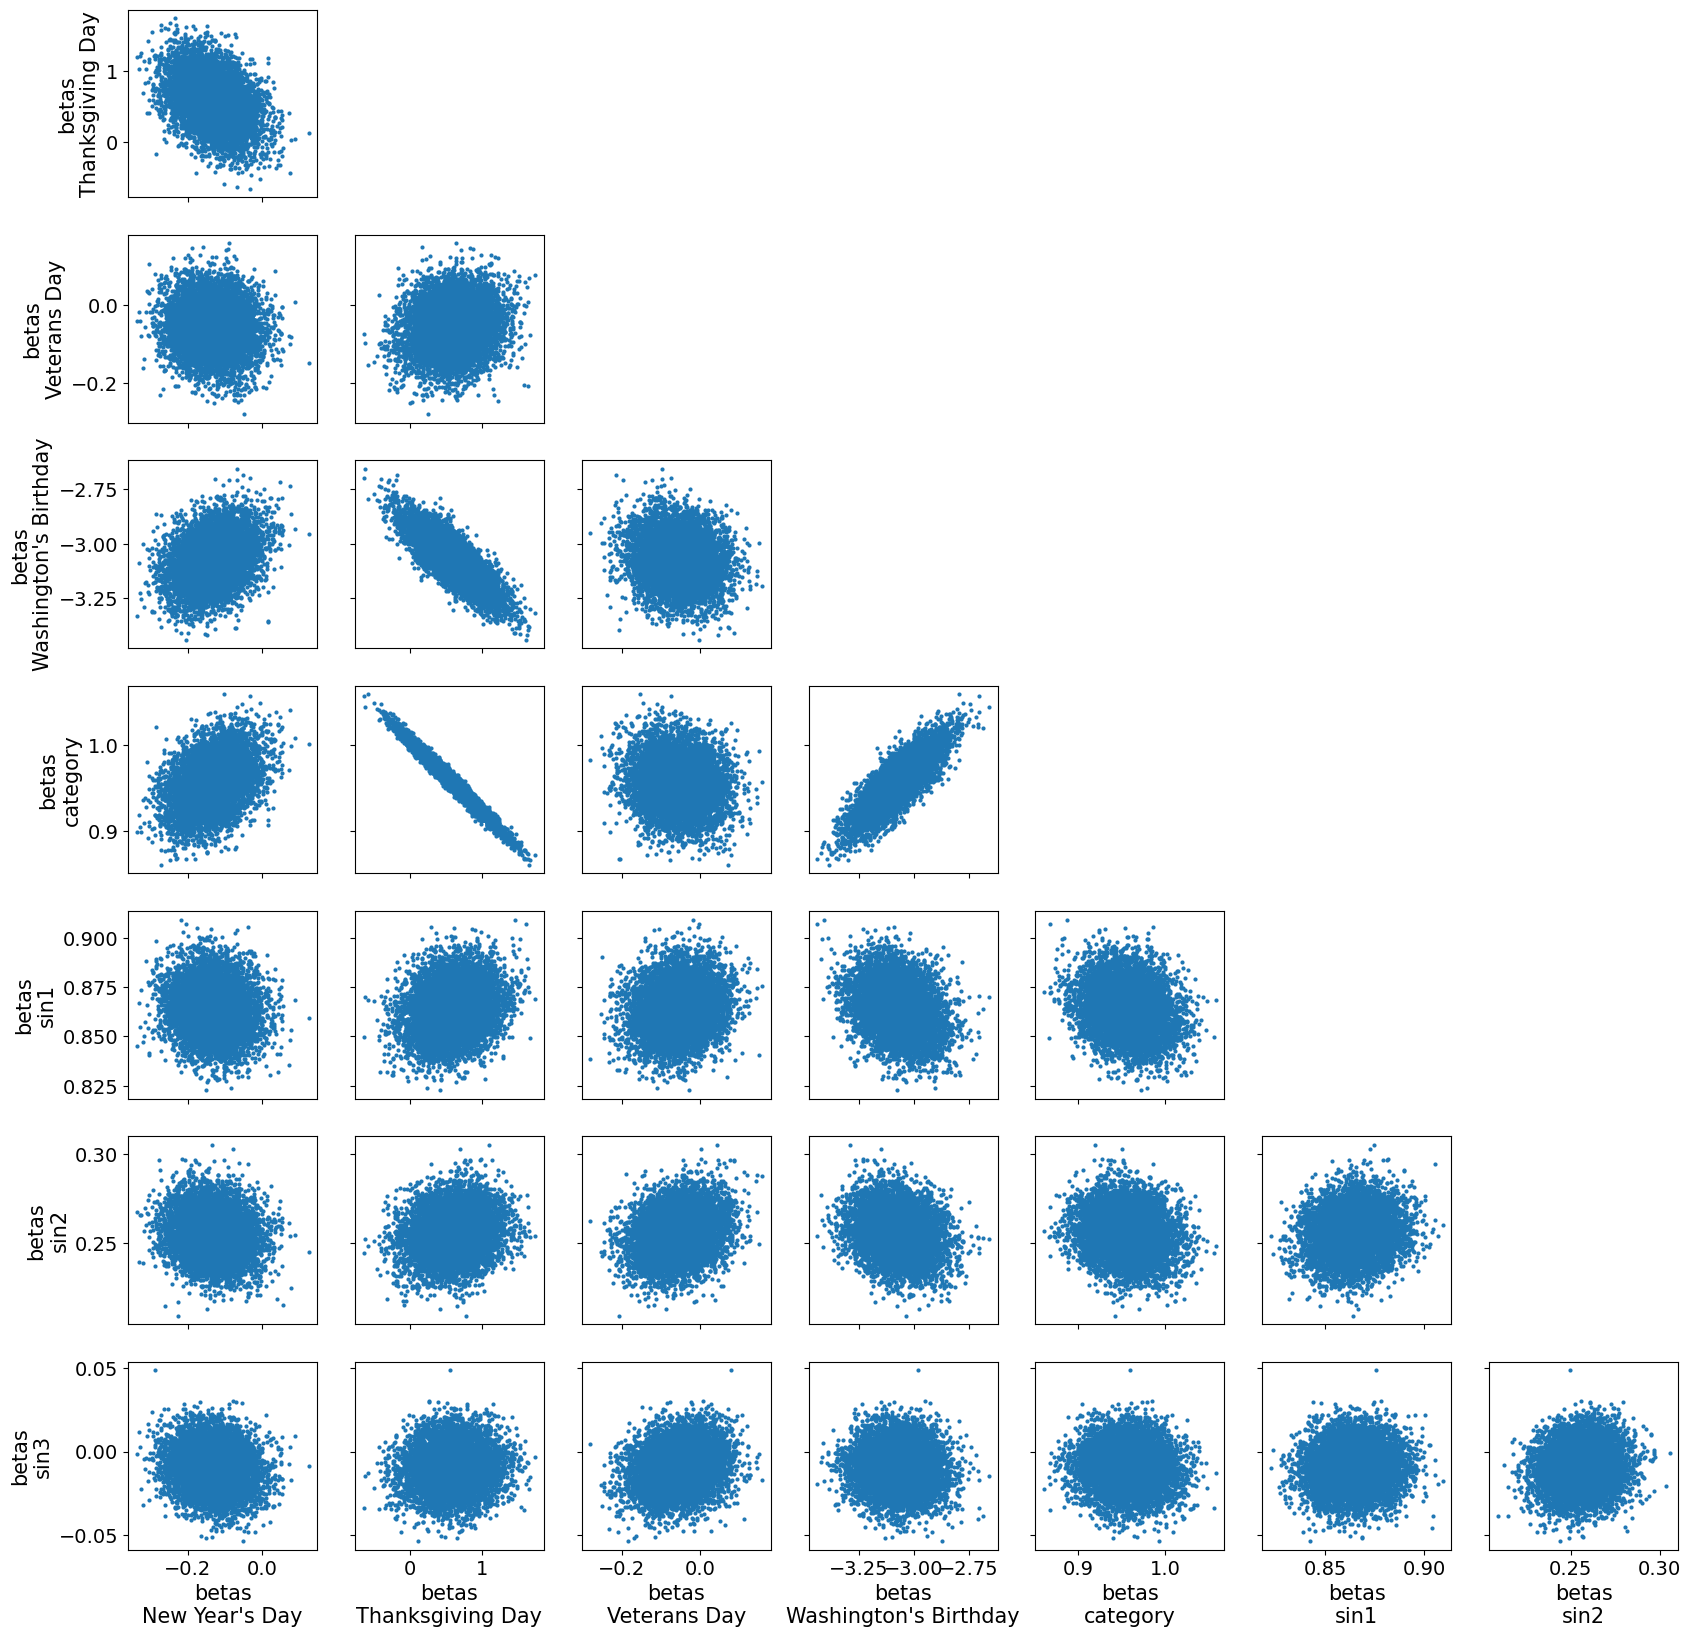

In [114]:
pm.plot_pair(trace, figsize=(20, 20), var_names=["betas"], coords={'IVS': data.columns[-8:]});

In [117]:
full_data.corr()

,"Birthday of Martin Luther King, Jr.",Christmas Day,Columbus Day,Independence Day,Juneteenth National Independence Day,Labor Day,Memorial Day,New Year's Day,Thanksgiving Day,Veterans Day,Washington's Birthday,category,target
"Birthday of Martin Luther King, Jr.",1.000000,-0.016276,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,0.009580,0.048876
Christmas Day,-0.016276,1.000000,-0.016276,-0.016276,-0.016276,-0.016276,-0.016276,-0.016276,-0.016276,-0.016276,-0.016276,-0.014700,0.003699
Columbus Day,-0.020000,-0.016276,1.000000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.010119,-0.079096
Independence Day,-0.020000,-0.016276,-0.020000,1.000000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,0.179354,0.295690
Juneteenth National Independence Day,-0.020000,-0.016276,-0.020000,-0.020000,1.000000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.000110,0.007410
Labor Day,-0.020000,-0.016276,-0.020000,-0.020000,-0.020000,1.000000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.001088,-0.056180
Memorial Day,-0.020000,-0.016276,-0.020000,-0.020000,-0.020000,-0.020000,1.000000,-0.020000,-0.020000,-0.020000,-0.020000,-0.015179,0.000943
New Year's Day,-0.020000,-0.016276,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,1.000000,-0.020000,-0.020000,-0.020000,-0.075005,-0.056771
Thanksgiving Day,-0.020000,-0.016276,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,1.000000,-0.020000,-0.020000,0.937702,0.807085
Veterans Day,-0.020000,-0.016276,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,1.000000,-0.020000,-0.001335,-0.050288


<Axes: >

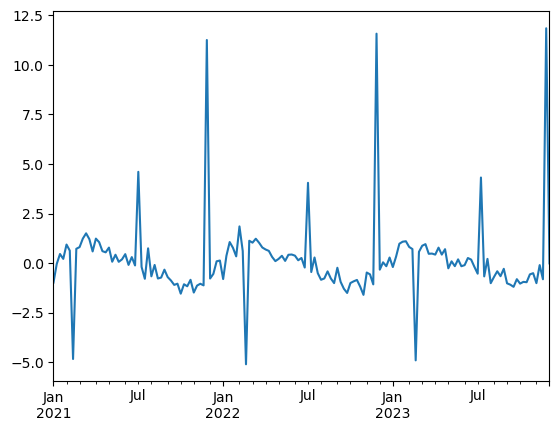

In [115]:
full_data['target'].plot()